# RRAM Relaxation 1/f Fitting

This notebook contains the fitting for 1/f RRAM relaxation data across three technologies (A, B, C). It loads and processes the measurements taken for each technology to enable fitting and understanding of the data.

In [1]:
# Imports
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats

%config InlineBackend.figure_format = 'svg'

## Load the technology and its settings

Below, choose which technology to load data and settings for:

In [2]:
# Choose technology here
TECH = 'A'

# Load settings for technology
with open(f"data/tech{TECH}/settings.json") as sfile:
    settings = json.load(sfile)

## Load the conductance data vs. time
Here, we will load the full dataset of conductance over time at room temperature to look at the 1/f behaviors of cells.

In [4]:
# Load data for technology
colnames = ["addr", "time", "r", "g"]
data = pd.read_csv(f"data/tech{TECH}/relaxdata.tsv.gz", names=colnames, sep='\t')
#data = data[data["addr"] % 2 == 0] # use only even addresses (odd addresses have weird behavior due to 2T2R architecture)
data["time"] -= data.groupby("addr")["time"].transform("first") # start from t=0 for each addr
data["gi"] = data.groupby("addr")["g"].transform("first") # get initial conductance each addr was programmed to
data["range"] = np.int32(data["gi"] / settings["gmax"] * 32) # get initial conductance range each addr was programmed to
data.head()

,addr,time,r,g,gi,range
0,80000,0.000000,337532.079408,0.000003,0.000003,0
1,80000,0.002000,373198.486437,0.000003,0.000003,0
2,80000,0.003998,283369.159874,0.000004,0.000003,0
3,80000,0.005997,280555.408797,0.000004,0.000003,0
4,80000,0.007995,266026.890670,0.000004,0.000003,0


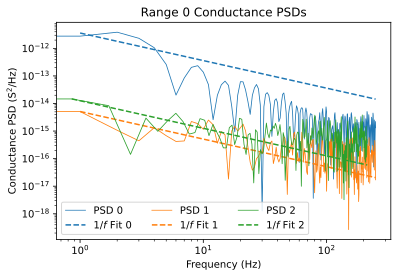

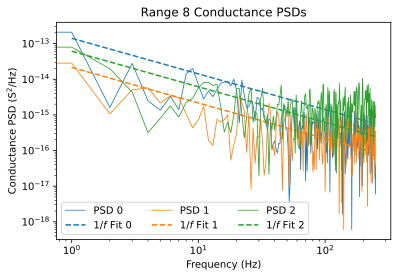

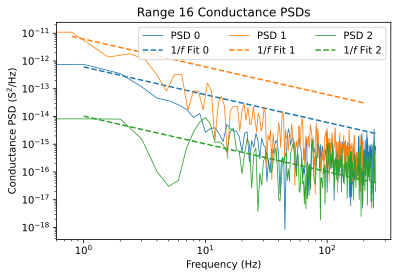

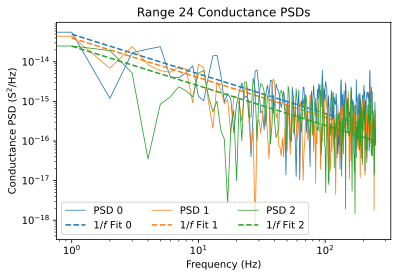

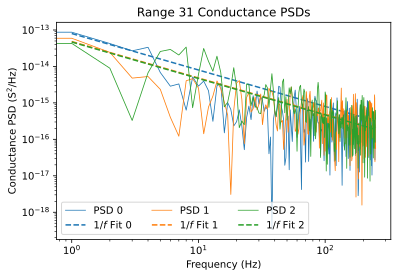

In [5]:
# Plot some 1/f PSDs
for r in list(range(0, 32, 8)) + [31]:
    # Data for some cells within range r
    plt.figure(figsize=(6,4))
    for cell, a in enumerate(data[data["range"] == r]["addr"].unique()[:3]):
        # Select which addr is being studied
        # print(f"addr = {a}")
        d = data[(data["addr"] == a) & (data["time"] < 10)]
        gvals = d.drop_duplicates(subset=["time"]).sort_values(["time"])

        # Compute sampling time
        fs = 1/np.median(np.gradient(gvals['time']))
        # print(f"fs = {fs}")
        freq, p = scipy.signal.welch(gvals["g"], fs, nperseg=len(gvals["g"]))

        # Fit functions
        fitfn = lambda f, c: c / f
        fit = scipy.optimize.curve_fit(fitfn, freq[1:], p[1:])
        # print(f"1/f fit coefficient = {fit[0][0]}")

        # Plot PSD and fits
        plt.plot(freq, p, linewidth=0.8, label=f"PSD {cell}")
        color = plt.gca().lines[-1].get_color()
        plt.plot(freq[1:], fitfn(freq[1:], fit[0][0]), '--', color=color, label=f"$1/f$ Fit {cell}")
    plt.title(f"Range {r} Conductance PSDs")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Conductance PSD (S$^2$/Hz)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(ncol=3)
    plt.savefig(f"figs/tech{TECH}/1overf-tech{TECH}-range{r}.png", dpi=300)
    plt.show()

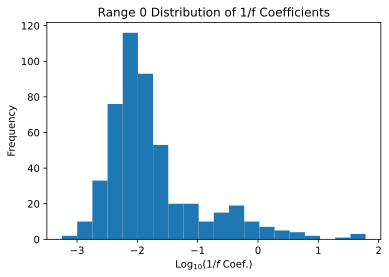

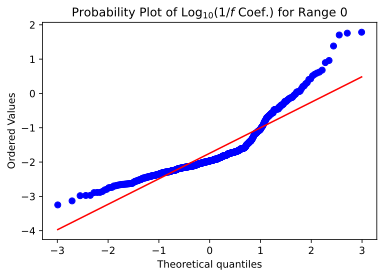

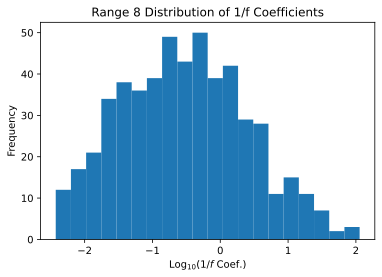

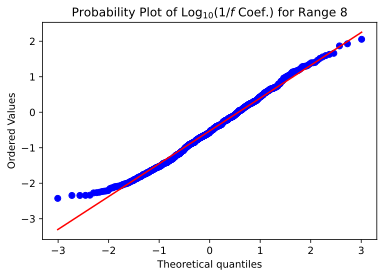

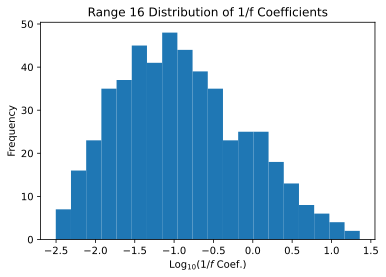

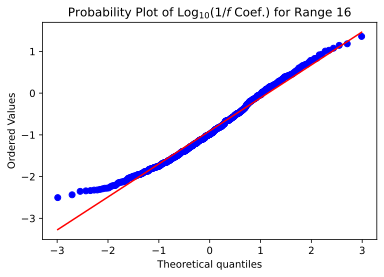

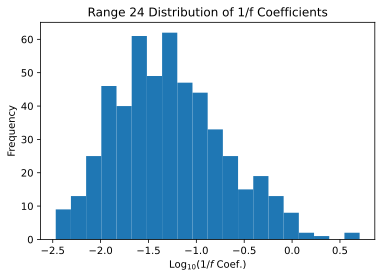

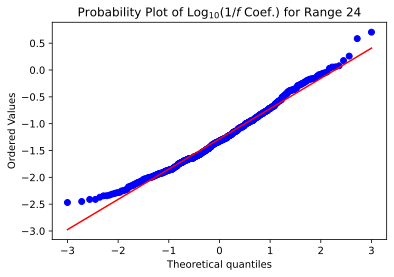

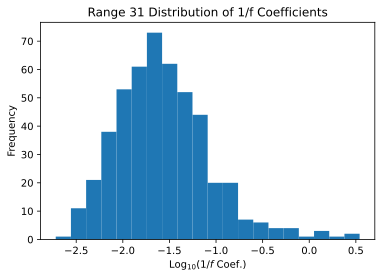

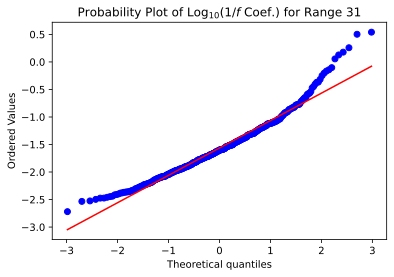

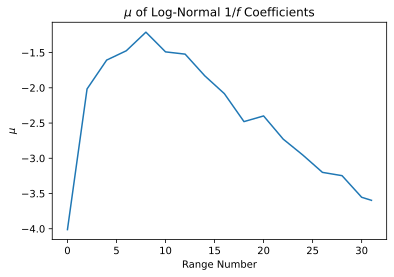

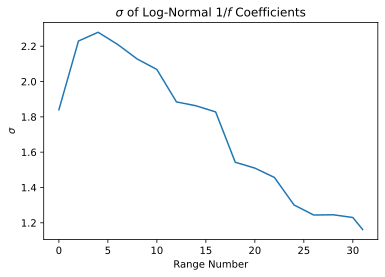

In [6]:
# 1/f coefficient statistics
fitfn = lambda f, c: c / f
fitfnloglog = lambda logf, c: c - logf

# Noise fitting function
def noise_fit(gvals, loglogfit=False):
    gvals = gvals.drop_duplicates(subset=['time']).sort_values(["time"])
    freq, p = scipy.signal.welch(gvals["g"]*10**6, fs=1/np.median(np.gradient(gvals["time"])), nperseg=len(gvals["g"]))
    if loglogfit:
        popt, pcov = scipy.optimize.curve_fit(fitfnloglog, np.log10(freq[1:]), np.log10(p[1:]))
        return 10**popt[0]
    else:
        popt, pcov = scipy.optimize.curve_fit(fitfn, freq[1:], p[1:])
        return popt[0]

# Log-normal fitting of 1/f coefficients
mus, sigmas = [], []
ranges = list(range(0, 32, 2)) + [31]
for r in ranges:
    # Fit 1/f coefficients
    coefs = data[(data["range"]==r) & (data["time"] < 10)].groupby("addr")[["g", "time"]].apply(noise_fit)
    
    if r in list(range(0, 32, 8)) + [31]:
        # Plot log-normal histogram
        plt.hist(np.log10(coefs), bins=20)
        plt.title(f"Range {r} Distribution of 1/f Coefficients")
        plt.xlabel("Log$_{{10}}$($1/f$ Coef.)")
        plt.ylabel("Frequency")
        plt.show()

        # Plot log-normal fit
        scipy.stats.probplot(np.log10(coefs), dist='norm', plot=plt, fit=True)
        plt.title(f"Probability Plot of Log$_{{10}}$($1/f$ Coef.) for Range {r}")
        plt.savefig(f"figs/tech{TECH}/1overf-coefln-tech{TECH}-range{r}.png", dpi=300)
        plt.show()

    # Get log-normal fit parameters
    mu, sigma = scipy.stats.norm.fit(np.log(coefs))
    mus.append(mu)
    sigmas.append(sigma)

# Plot mus
plt.plot(ranges, mus)
plt.title(f"$\mu$ of Log-Normal $1/f$ Coefficients")
plt.xlabel("Range Number")
plt.ylabel("$\mu$")
plt.savefig(f"figs/tech{TECH}/1overf-tech{TECH}-lognorm-mu.pdf")
plt.show()

# Plot sigmas
plt.plot(ranges, sigmas)
plt.title(f"$\sigma$ of Log-Normal $1/f$ Coefficients")
plt.xlabel("Range Number")
plt.ylabel("$\sigma$")
plt.savefig(f"figs/tech{TECH}/1overf-tech{TECH}-lognorm-sigma.pdf")
plt.show()